In [73]:
import pandas as pd 
import numpy as np 
import os 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Objectif : prédire le nombre de bornes de recharges dans le futur

In [74]:
URL_DATASET = 'https://data.enedis.fr/api/explore/v2.1/catalog/datasets/nombre-total-de-points-de-charge/exports/csv?lang=fr&timezone=Europe%2FBerlin&use_labels=true&delimiter=%3B'
df = pd.read_csv(URL_DATASET, sep = ';')
df.sample(5)

,Trimestre,Ouvert au public,Particulier,Société
13,2021 T1,37491,307174,269327
9,2015 T4,11113,37448,42891
29,2018 T4,26254,106839,104895
2,2020 T1,31081,172822,167797
33,2017 T2,19750,68509,68930


In [75]:
df.shape

(35, 4)

In [76]:
def transform_col1(row):
    year = row.split(' ')[0]
    return year

def transform_col2(row):
    sem = row.split('T')[1]
    return sem


df['Semestre'] = df['Trimestre'].apply(transform_col2)
df['Année'] = df['Trimestre'].apply(transform_col1)

def transform_col3(row): 
    row = row.split('T')
    year = row[0]
    sem_nb = row[1]
    return year + 'Q' + sem_nb
df['Trimestre'] = df['Trimestre'].apply(transform_col3)
df['Trimestre'] = pd.to_datetime(df['Trimestre'], format='%Y Q%m')
df.head()

,Trimestre,Ouvert au public,Particulier,Société,Semestre,Année
0,2023-03-01,109856,906942,652131,3,2023
1,2022-03-01,71630,623836,446585,3,2022
2,2020-01-01,31081,172822,167797,1,2020
3,2016-04-01,16220,57039,59408,4,2016
4,2020-04-01,34686,267371,237863,4,2020


In [77]:
list(df.columns)

['Trimestre',
 'Ouvert au public',
 'Particulier',
 'Société',
 'Semestre',
 'Année']

In [78]:
df.sort_values(by = ['Année', 'Semestre'], inplace = True)
df.head()

,Trimestre,Ouvert au public,Particulier,Société,Semestre,Année
20,2015-01-01,8478,25638,34746,1,2015
10,2015-02-01,10086,29662,37933,2,2015
34,2015-03-01,10928,32278,38681,3,2015
9,2015-04-01,11113,37448,42891,4,2015
26,2016-01-01,12830,43284,48013,1,2016


In [79]:
def total(dataframe):
    dataframe['Total'] = dataframe['Ouvert au public'] + dataframe['Particulier'] + dataframe['Société']
    return dataframe

df = total(df)
df.head()

,Trimestre,Ouvert au public,Particulier,Société,Semestre,Année,Total
20,2015-01-01,8478,25638,34746,1,2015,68862
10,2015-02-01,10086,29662,37933,2,2015,77681
34,2015-03-01,10928,32278,38681,3,2015,81887
9,2015-04-01,11113,37448,42891,4,2015,91452
26,2016-01-01,12830,43284,48013,1,2016,104127


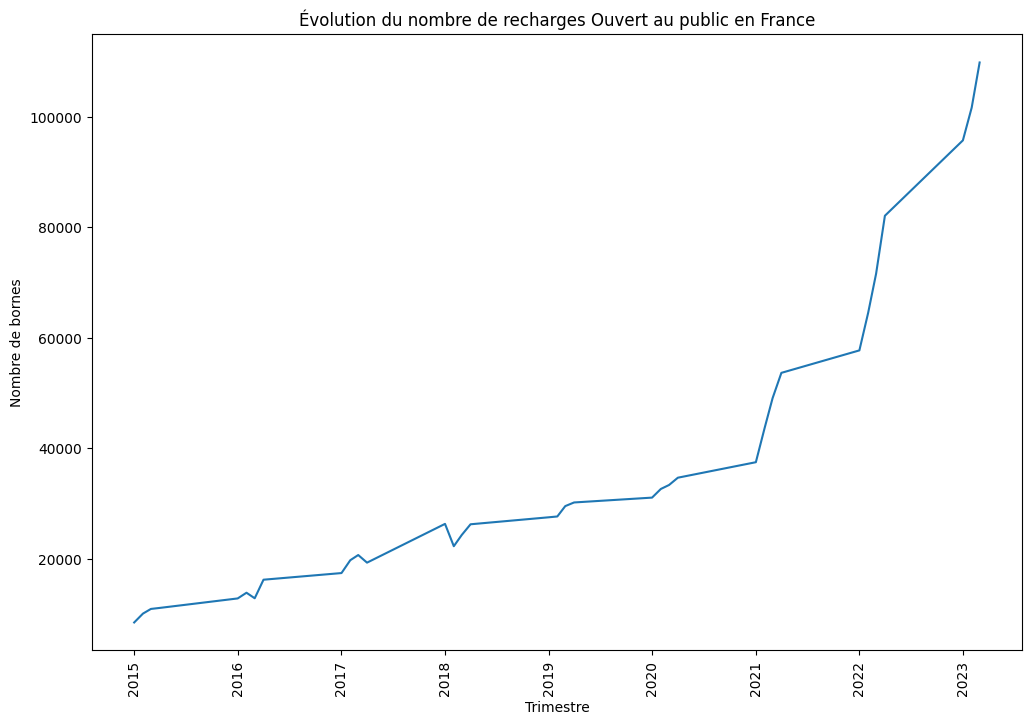

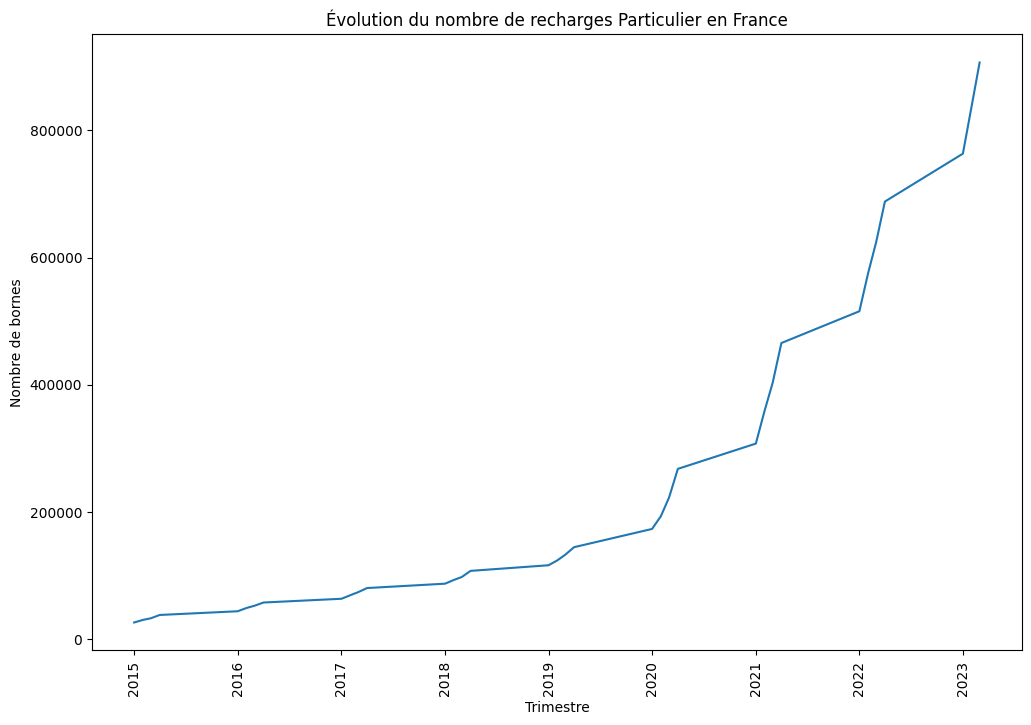

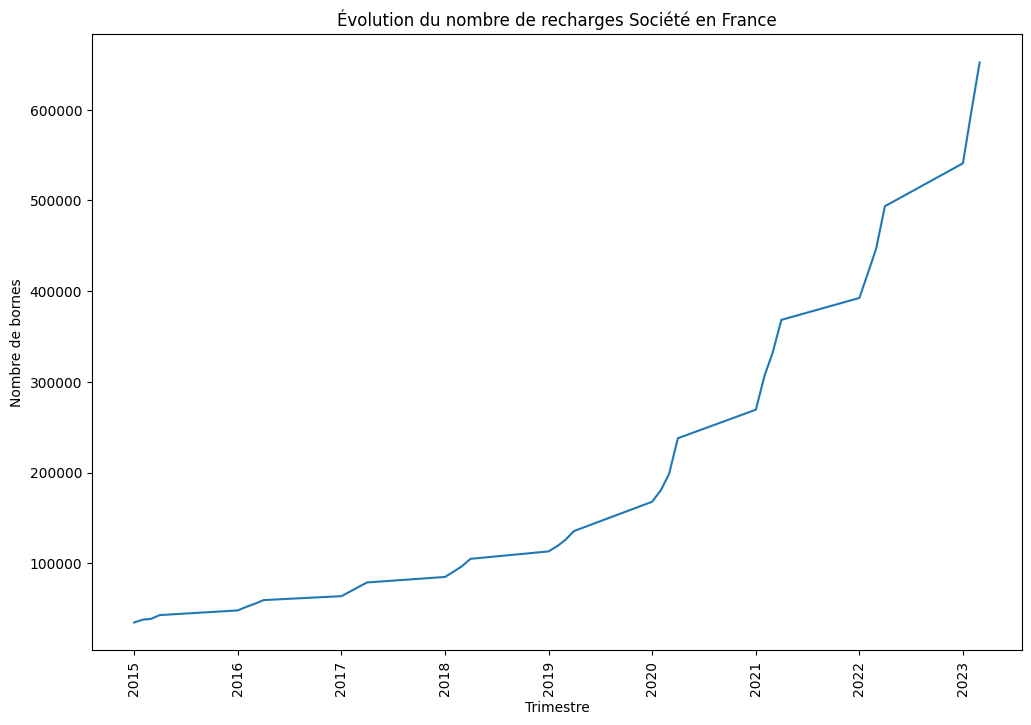

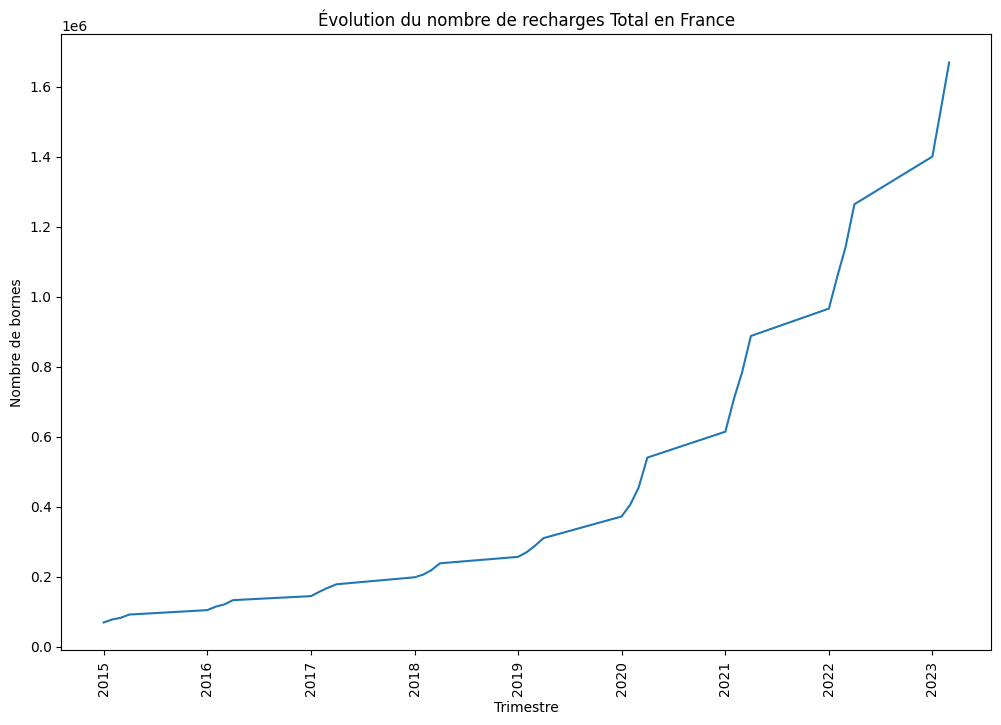

In [80]:
for col in ['Ouvert au public', 'Particulier', 'Société', 'Total']:
    plt.figure(figsize = (12,8))
    plt.plot(df['Trimestre'], df[col])
    plt.xlabel('Trimestre')
    plt.xticks(rotation=90)
    plt.ylabel('Nombre de bornes')
    plt.title(f'Évolution du nombre de recharges {col} en France')
    plt.show()

Nous avons très peu d'informations et possédons seulement des périodes. C'est pourquoi nous choisissons une simple régression linéaire.

Nous nous accordons à dire qu'avec si peu de features, les prédictions du modèle sont vraiment à prendre avec des pincettes. Toutefois, nous voulions quand même nous essayer à la prédiction dans ce projet.

In [88]:
X = df[['Semestre', 'Année']]
y = df['Total']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)  #prédictions sur l'ensemble de test

# Évaluer les performances du modèle
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Afficher les résultats
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 416459288139.51404
R-squared: -2.8520673877147535


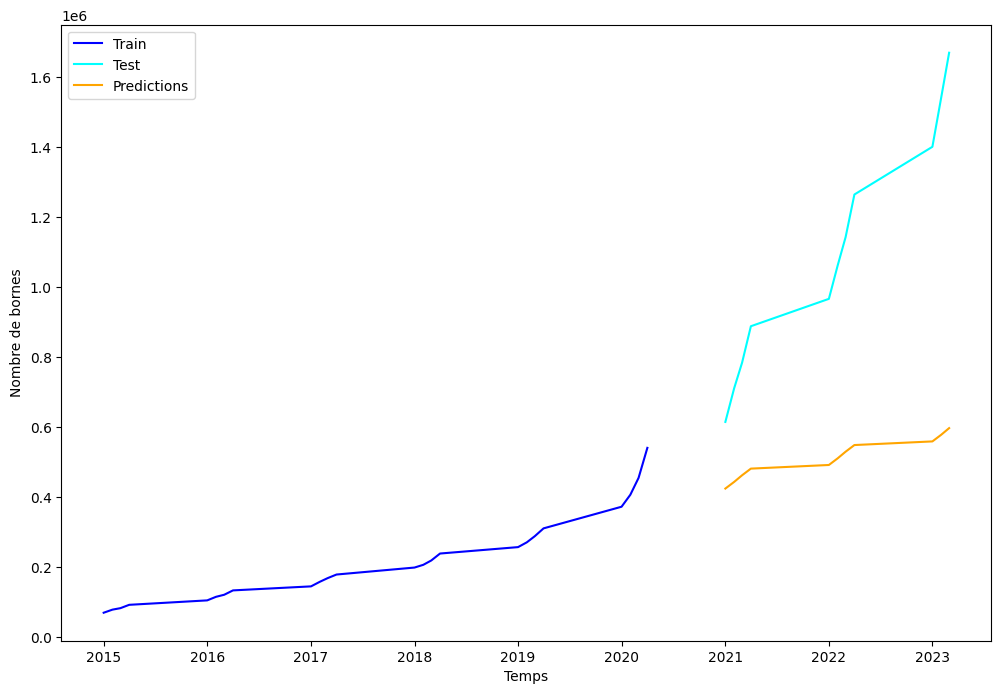

In [89]:
plt.figure(figsize=(12,8))
date_train = [year + ' Q' + sem for sem, year in X_train[['Semestre', 'Année']].values]
date_test = [year + ' Q' + sem for sem, year in X_test[['Semestre', 'Année']].values]
plt.plot(pd.to_datetime(date_train, format='%Y Q%m'), y_train, color = 'blue', label = 'Train')
plt.plot(pd.to_datetime(date_test, format='%Y Q%m'), y_test, color = 'cyan', label = 'Test')
plt.plot(pd.to_datetime(date_test, format='%Y Q%m'), y_pred, color = 'orange', label = 'Predictions')
plt.legend()
plt.xlabel('Temps')
plt.ylabel('Nombre de bornes')
plt.show()

In [90]:
# on mélange les dates d'entraînement en enlevant shuffle = False
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)  #prédictions sur l'ensemble de test

# Évaluer les performances du modèle
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Afficher les résultats
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 42673224090.80993
R-squared: 0.4712165057853327


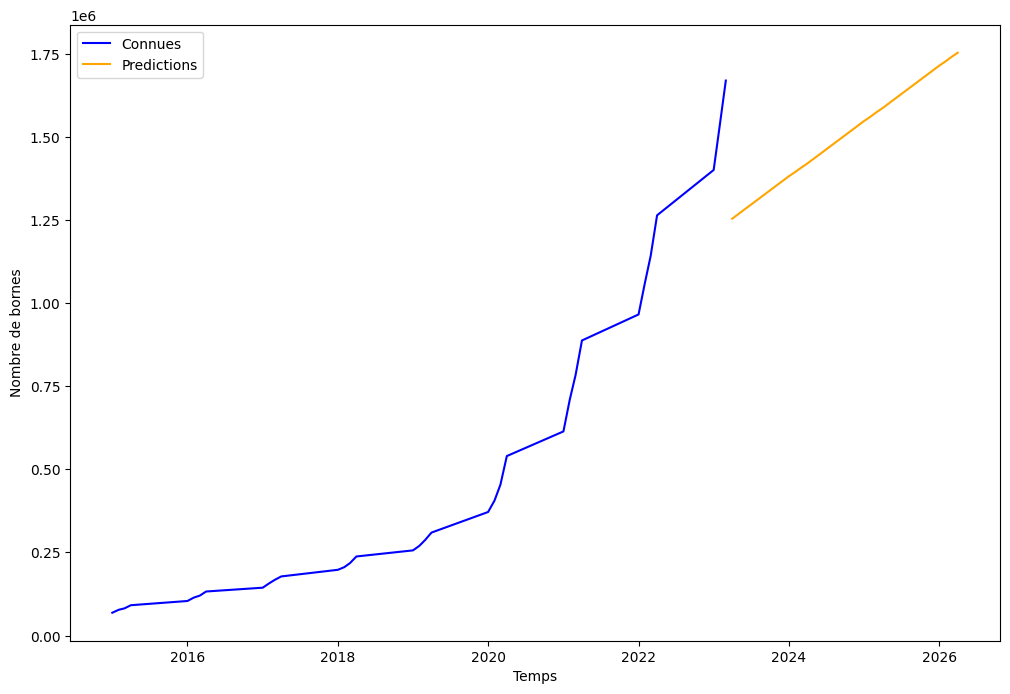

In [101]:
X_pred = pd.DataFrame([['4', '2023'], ['1', '2024'], ['2', '2024'], ['3', '2024'], ['4', '2024'],
          ['1', '2025'], ['2', '2025'], ['3', '2025'], ['4', '2025'], 
          ['1', '2026'], ['2', '2026'], ['3', '2026'], ['4', '2026']], columns = ['Semestre', 'Année'])
date_predictions = [year + ' Q' + sem for sem, year in X_pred[['Semestre', 'Année']].values]
predictions = model.predict(X_pred)

plt.figure(figsize=(12,8))
date = [year + ' Q' + sem for sem, year in X[['Semestre', 'Année']].values]
plt.plot(pd.to_datetime(date, format='%Y Q%m'), y, color = 'blue', label = 'Connues')
plt.plot(pd.to_datetime(date_predictions, format='%Y Q%m'), predictions, color = 'orange', label = 'Predictions')
plt.legend()
plt.xlabel('Temps')
plt.ylabel('Nombre de bornes')
plt.show()